In [6]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import floris.tools.visualization as vis
import floris.tools.cut_plane as cp
from floris.tools.optimization import YawOptimizationWindRose
import floris.tools.wind_rose as rose
import floris.tools.power_rose as pr
import numpy as np
import pandas as pd

ImportError: cannot import name 'YawOptimizationWindRose' from 'floris.tools.optimization' (C:\Users\pduffy\Documents\repos\floris\floris\tools\optimization.py)

In [3]:
# Instantiate the FLORIS object
fi = wfct.floris_utilities.FlorisInterface("examples\example_input.json")

# Define wind farm coordinates and layout
wf_coordinate = [39.8283, -98.5795]

# Set wind farm to N_row x N_row grid with constant spacing 
# (2 x 2 grid, 5 D spacing)
D = fi.floris.farm.turbines[0].rotor_diameter
N_row = 2
spc = 5
layout_x = []
layout_y = []
for i in range(N_row):
	for k in range(N_row):
		layout_x.append(i*spc*D)
		layout_y.append(k*spc*D)
N_turb = len(layout_x)

fi.reinitialize_flow_field(layout_array=(layout_x, layout_y),wind_direction=270.0,wind_speed=8.0)
fi.calculate_wake()

Plotting the FLORIS flowfield...
Assuming grid with spacing 10
 215.200  114.400   18.990
Nearest value in z to 90.00 is 84.76


Text(0.5, 1.0, 'Baseline flow for U = 8 m/s, Wind Direction = 270$^\\circ$')

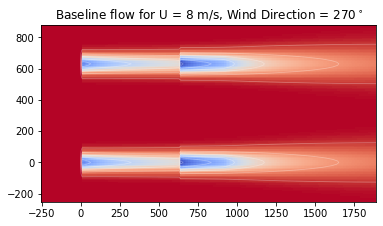

In [4]:
# set min and max yaw offsets for optimization
min_yaw = 0.0
max_yaw = 25.0

# Define minimum and maximum wind speed for optimizing power. 
# Below minimum wind speed, assumes power is zero.
# Above maximum_ws, assume optimal yaw offsets are 0 degrees
minimum_ws = 8.0
maximum_ws = 9.0

# ================================================================================
print('Plotting the FLORIS flowfield...')
# ================================================================================

# Initialize the horizontal cut
hor_plane = wfct.cut_plane.HorPlane(
    fi.get_flow_data(),
    fi.floris.farm.turbines[0].hub_height
)

# Plot and show
fig, ax = plt.subplots()
wfct.visualization.visualize_cut_plane(hor_plane, ax=ax)
ax.set_title('Baseline flow for U = 8 m/s, Wind Direction = 270$^\circ$')



Importing wind rose data...
Correcting negative Overhang:-7.5


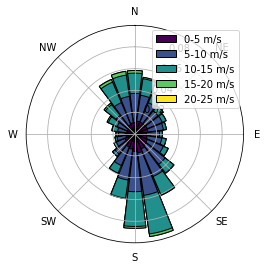

In [5]:
# ================================================================================
print('Importing wind rose data...')
# ================================================================================

# Create wind rose object and import wind rose dataframe using WIND Toolkit HSDS API.
# Alternatively, load existing .csv file with wind rose information.
calculate_new_wind_rose = False

wind_rose = rose.WindRose()

if calculate_new_wind_rose:

	wd_list = np.arange(0,360,5)
	ws_list = np.arange(0,26,1)

	df = wind_rose.import_from_wind_toolkit_hsds(wf_coordinate[0],
	                                                    wf_coordinate[1],
	                                                    ht = 100,
	                                                    wd = wd_list,
	                                                    ws = ws_list,
	                                                    limit_month = None,
	                                                    st_date = None,
	                                                    en_date = None)

else:
	df = wind_rose.load('windtoolkit_geo_center_us.p')

# plot wind rose
wind_rose.plot_wind_rose()



In [ ]:
# =============================================================================
print('Finding baseline and optimal yaw angles in FLORIS...')
# =============================================================================

# Instantiate the Optimization object
yaw_opt = YawOptimizationWindRose(fi, df.wd, df.ws,
                               minimum_yaw_angle=min_yaw,
                               maximum_yaw_angle=max_yaw,
                               minimum_ws=minimum_ws,
                               maximum_ws=maximum_ws)

# Determine baseline power with and without wakes
df_base = yaw_opt.calc_baseline_power()


# combine wind farm-level power into one dataframe
df_power = pd.DataFrame({'ws':df.ws,'wd':df.wd, \
    'freq_val':df.freq_val,'power_no_wake':df_base.power_no_wake, \
    'power_baseline':df_base.power_baseline})

# Set up the power rose
df_turbine_power_no_wake = pd.DataFrame([list(row) for row in df_base['turbine_power_no_wake']],columns=[str(i) for i in range(1,N_turb+1)])
df_turbine_power_no_wake['ws'] = df.ws
df_turbine_power_no_wake['wd'] = df.wd
df_turbine_power_baseline = pd.DataFrame([list(row) for row in df_base['turbine_power_baseline']],columns=[str(i) for i in range(1,N_turb+1)])
df_turbine_power_baseline['ws'] = df.ws
df_turbine_power_baseline['wd'] = df.wd

case_name = 'Example '+str(N_row)+' x '+str(N_row)+ ' Wind Farm'
power_rose = pr.PowerRose(case_name, df_power, df_turbine_power_no_wake, df_turbine_power_baseline)

# Display AEP analysis
fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(6.4, 6.5))
power_rose.plot_by_direction(axarr)
power_rose.report()

plt.show()


In [ ]:
# Plot and show
fig, ax = plt.subplots()
wfct.visualization.plot_turbines(ax, layout_x, layout_y, yaw_angles=np.zeros(len(layout_x)), D=D)
ax.set_title('Layout')
